In [1]:
#from dtale import show
import pandas as pd
import polars as pl
from datetime import datetime
from dateutil.relativedelta import relativedelta
from datetime import datetime,date
#from changepy import pelt
#from changepy.costs import normal_var, normal_mean, normal_meanvar, exponential, poisson
import altair as alt
from bokeh.plotting import figure, show, curdoc
from bokeh.transform import linear_cmap
from bokeh.palettes import Paired
from bokeh.models import ColumnDataSource, HoverTool, CrosshairTool,Span,Range1d,LinearAxis,Select,DataTable,TableColumn,StringEditor,DateFormatter
from bokeh.io import output_notebook
import Rbeast as rb

output_notebook()
curdoc().theme = 'light_minimal'
today=date.today().replace(day=1)

#fn,reg,loc,gb='APAC','Region','South Pacific','CatalogNumber'
fn,reg,loc,gb='APAC','Region','South Pacific','CatalogNumber'
#fn,reg,loc,gb='APAC','Country','CHINA','CatalogNumber'
#fn,reg,loc,gb='Trauma and Extremities','Country','UNITED STATES','CatalogNumber'
#fn,reg,loc,gb='Europe','Stryker Group Region','EUROPE','IBP Level 7'
sk=300

Loading BokehJS ...

In [2]:
#dfh=pl.read_parquet(f"C:\\Users\\smishra14\\OneDrive - Stryker\\data\\hierarchy.parquet")
#df=pl.read_parquet(f"C:\\Users\\smishra14\\OneDrive - Stryker\\data\\{fn}.parquet")
dfh=pl.read_parquet(f"hierarchy.parquet")
df=pl.read_parquet(f"{fn}.parquet")
df=df.filter(pl.col('SALES_DATE')<=datetime(today.year,today.month,1)-relativedelta(months=1))
if loc=='EUROPE':
    df=df.join(dfh[['CatalogNumber','IBP Level 7']],how='left',on='CatalogNumber')
#df=pl.read_parquet(f"C:\\Users\\smishra14\\OneDrive - Stryker\\data\\{fn}.parquet")
df=df.filter(pl.col(reg)==loc)[['Region',gb,'SALES_DATE','`Act Orders Rev','Act Orders Rev Val','`Fcst DF Final Rev','Fcst DF Final Rev Val','L2 Stat Final Rev']]
df=df.group_by(['Region',gb,'SALES_DATE']).sum()
#df=df.with_columns((pl.col('Fcst DF Final Rev Val')/pl.col('`Fcst DF Final Rev')).alias('ASP'))
#df=df.filter(pl.col('SALES_DATE')<=datetime(today.year,today.month,1)-relativedelta(months=1))
df = df.with_columns((pl.col('Act Orders Rev Val')/pl.col('`Act Orders Rev')).alias('ASP'))
#df = df.with_columns((pl.when(pl.col('SALES_DATE')<=datetime(today.year,today.month,1)-relativedelta(months=1)).then((pl.col('Act Orders Rev Val')/pl.col('`Act Orders Rev'))).otherwise((pl.col('Fcst DF Final Rev Val')/pl.col('`Fcst DF Final Rev')))).over('CatalogNumber').alias('ASP'))
cc=df.drop_nulls().group_by(gb).sum().sort('`Act Orders Rev',descending=True)[[gb,'`Act Orders Rev']]
#Changepoint
# 0620050250 - SSP
# 0408800000 - SSP
# 0416801100 - SSP

In [29]:
def update(cat):
    #it = '0210114100'
    df1=df.filter(pl.col(gb)==cat)
    df1=df1.group_by([gb,'SALES_DATE']).sum()
    df1=df1[['SALES_DATE','`Act Orders Rev']]
    df1=df1.filter(pl.col('SALES_DATE')<today-relativedelta(months=2))
    df1=df1.rename({'`Act Orders Rev':'order'})
    df1=df1.to_pandas()
    df1=df1.sort_values('SALES_DATE')
    o=rb.beast(df1['order'], deltat='1 month', period = '1.0 year',quite=True,print_progress=False,print_options=False)
    #df2=pd.DataFrame(data={'index':o.time,'month':df1['ds'],,'month':df1['ds'].sort_values()})
    df2=df1.copy()
    df2['index']=o.time
    df2=df2.merge(pd.DataFrame({'tcp':o.trend.cp,'tcppr':o.trend.cpPr}),left_on='index',right_on='tcp',how='left')
    df2=df2.merge(pd.DataFrame({'scp':o.season.cp,'scppr':o.season.cpPr}),left_on='index',right_on='scp',how='left')
    df2=df2.fillna(0)
    ss=ColumnDataSource(df2)
    p=figure(x_axis_type='datetime',height=400,width=800)
    p.line(x='SALES_DATE', y='order', width=1.8, line_alpha=0.8,source=ss)
    p.add_tools(HoverTool(tooltips=[('order','@order{0,0}'),('SALES_DATE','@SALES_DATE{%b-%Y}'),('tcppr','@tcppr')],formatters={'@SALES_DATE':'datetime'},mode='vline'))
    p.add_tools(CrosshairTool(dimensions='height'))
    p.vbar(x='SALES_DATE',top='tcppr', line_width=5, line_alpha=.5, source=ss,y_range_name="foo",color='red')
    p.extra_y_ranges = {"foo": Range1d(start=0, end=1)}
    p.add_layout(LinearAxis(y_range_name="foo"), 'right')
    return show(p)

#dt=DataTable(source=ColumnDataSource(cc.to_pandas()),columns=[TableColumn(field=i,editor=StringEditor()) for i in cc.columns],  width=400, height=280,editable=True)
#show(dt)
#cc['CatalogNumber'][:30]
'''df2=df1.clone()
df2=df2.with_columns(index=o.time)
aa=pl.DataFrame({'tcp':o.trend.cp,'tcppr':o.trend.cpPr})
bb=pl.DataFrame({'scp':o.season.cp,'scppr':o.season.cpPr})
df2=df2.join(aa,left_on='index',right_on='tcp',how='left')
df2=df2.join(bb,left_on='index',right_on='scp',how='left')
df2'''

"df2=df1.clone()\ndf2=df2.with_columns(index=o.time)\naa=pl.DataFrame({'tcp':o.trend.cp,'tcppr':o.trend.cpPr})\nbb=pl.DataFrame({'scp':o.season.cp,'scppr':o.season.cpPr})\ndf2=df2.join(aa,left_on='index',right_on='tcp',how='left')\ndf2=df2.join(bb,left_on='index',right_on='scp',how='left')\ndf2"

In [4]:
data=pl.DataFrame(schema=['Region',gb,'SALES_DATE','order','index','tcppr','scppr'])
for rr in df['Region'].unique():
    for i in cc[gb][:sk]:
        df1=df.filter(pl.col(gb)==i)
        df1=df1.filter(pl.col('Region')==rr)
        df1=df1[['Region',gb,'SALES_DATE','`Act Orders Rev']]
        df1=df1.filter(pl.col('SALES_DATE')<today-relativedelta(months=1))
        df1=df1.rename({'`Act Orders Rev':'order'})
        #df1=df1.to_pandas()
        df1=df1.sort('SALES_DATE')
        if len(df1['order']>0)>24:
            #print(rr,i, len(df1['order']>0))
            o=rb.beast(df1['order'], deltat='1 month', period = '1.0 year',quite=True,print_progress=False,print_options=False)
            #df2=pd.DataFrame(data={'index':o.time,'month':df1['ds'],,'month':df1['ds'].sort_values()})
            df2=df1.clone()
            df2=df2.with_columns(index=o.time)
            aa=pl.DataFrame({'tcp':o.trend.cp,'tcppr':o.trend.cpPr})
            bb=pl.DataFrame({'scp':o.season.cp,'scppr':o.season.cpPr})
            df2=df2.join(aa,left_on='index',right_on='tcp',how='left')
            df2=df2.join(bb,left_on='index',right_on='scp',how='left')
            df2=df2.filter((pl.col('tcppr')>.6) | (pl.col('scppr')>.6))
            data=pl.concat([data,df2['Region',gb,'SALES_DATE','order','index','tcppr','scppr']],how='diagonal_relaxed')
        #else:
            #print(i, len(df1['order']>0), "NOT LONG")

In [20]:
from jinja2 import Template
#data=data.rename({'ds':'SALES_DATE'})
#data=data.drop('index')
df2=df.filter(pl.col(gb).is_in(cc[gb][:sk])).sort('SALES_DATE')

#jinja2_template_string = open("C:\\Users\\smishra14\\OneDrive - Stryker\\python\\test1.html", 'r').read()
jinja2_template_string = open("test1.html", 'r').read()
template = Template(jinja2_template_string)
html = template.render(jdf=df.filter(pl.col('CatalogNumber').is_in(data['CatalogNumber'].unique())).sort('SALES_DATE').to_pandas().reset_index(drop=True).to_json(orient='records',date_format='iso'),
                       jdf2=data.to_pandas().reset_index(drop=True).to_json(orient='records',date_format='iso'),
                       sc2=list(data.to_pandas().reset_index(drop=True).columns),
                      gb=gb)
with open(f"{fn}-{loc}.html", "w") as fh:
    fh.write(html)

## Act with Forecast

In [19]:
df=pl.read_parquet(f"{fn}.parquet")
df=df.with_columns((pl.when(pl.col('SALES_DATE')<=datetime(today.year,today.month,1)-relativedelta(months=1)).then(pl.col('`Act Orders Rev')).otherwise(
                pl.col('`Fcst DF Final Rev'))).alias('actwfc'))
df=df.filter(pl.col(reg)==loc)[['Region',gb,'SALES_DATE','`Act Orders Rev','actwfc','`Fcst DF Final Rev','`Fcst Stat Final Rev']]
df=df.group_by(['Region',gb,'SALES_DATE']).sum()
cc=df.drop_nulls().group_by(gb).sum().sort('`Act Orders Rev',descending=True)[[gb,'`Act Orders Rev','actwfc']]

data=pl.DataFrame(schema=['Region',gb,'SALES_DATE','order','actwfc','index','tcppr','scppr'])
for rr in df['Region'].unique():
    for i in cc[gb][:sk]:
        df1=df.filter(pl.col(gb)==i)
        df1=df1.filter(pl.col('Region')==rr)
        df1=df1[['Region',gb,'SALES_DATE','`Act Orders Rev','actwfc']]
        #df1=df1.filter(pl.col('SALES_DATE')<today-relativedelta(months=1))
        df1=df1.rename({'`Act Orders Rev':'order'})
        #df1=df1.to_pandas()
        df1=df1.sort('SALES_DATE')
        if len(df1['order']>0)>24:
            #print(rr,i, len(df1['order']>0))
            o=rb.beast(df1['actwfc'], deltat='1 month', period = '1.0 year',quite=True,print_progress=False,print_options=False)
            #df2=pd.DataFrame(data={'index':o.time,'month':df1['ds'],,'month':df1['ds'].sort_values()})
            df2=df1.clone()
            df2=df2.with_columns(index=o.time)
            aa=pl.DataFrame({'tcp':o.trend.cp,'tcppr':o.trend.cpPr})
            bb=pl.DataFrame({'scp':o.season.cp,'scppr':o.season.cpPr})
            df2=df2.join(aa,left_on='index',right_on='tcp',how='left')
            df2=df2.join(bb,left_on='index',right_on='scp',how='left')
            df2=df2.filter((pl.col('tcppr')>.6)) #| (pl.col('scppr')>.6))
            ll=len(df2.filter(pl.any_horizontal(pl.col('SALES_DATE')==today-relativedelta(months=1),pl.col('SALES_DATE')==today)))
            if ll>0:
                #print(ll,df2['SALES_DATE'].unique())
                data=pl.concat([data,df2['Region',gb,'SALES_DATE','order','actwfc','index','tcppr','scppr']],how='diagonal_relaxed')

In [224]:
update(data['CatalogNumber'][3])

In [218]:
data

Region,CatalogNumber,SALES_DATE,order,actwfc,index,tcppr,scppr
str,str,datetime[μs],f64,f64,f32,f32,f32
"""United States""","""23514236S""",2024-07-01 00:00:00,288.0,288.0,4.25,0.665333,null
"""United States""","""13203042S""",2023-02-01 00:00:00,1555.0,1555.0,2.833333,0.939208,null
"""United States""","""13203042S""",2024-08-01 00:00:00,0.0,1086.0,4.333333,0.993917,null
"""United States""","""02273000S""",2024-08-01 00:00:00,0.0,1688.258108,4.333333,0.867333,0.841625
"""United States""","""705234""",2024-07-01 00:00:00,114.0,114.0,4.25,0.675208,0.102042
…,…,…,…,…,…,…,…
"""United States""","""661175""",2024-07-01 00:00:00,19.0,19.0,4.25,0.999667,0.100542
"""United States""","""23605065S""",2024-08-01 00:00:00,0.0,383.807356,4.333333,0.600167,0.385917
"""United States""","""661436""",2024-08-01 00:00:00,0.0,513.0,4.333333,0.990125,null


In [198]:
def update(cat):
    #it = '0210114100'
    df1=df.filter(pl.col(gb)==cat)
    df1=df1.group_by([gb,'SALES_DATE']).sum()
    df1=df1[['SALES_DATE','`Act Orders Rev','actwfc','`Fcst DF Final Rev']]
    #df1=df1.filter(pl.col('SALES_DATE')<today-relativedelta(months=2))
    df1=df1.rename({'`Act Orders Rev':'order'})
    df1=df1.to_pandas()
    df1=df1.sort_values('SALES_DATE')
    o=rb.beast(df1['actwfc'], deltat='1 month', period = '1.0 year',quite=True,print_progress=False,print_options=False)
    #df2=pd.DataFrame(data={'index':o.time,'month':df1['ds'],,'month':df1['ds'].sort_values()})
    df2=df1.copy()
    df2['index']=o.time
    df2=df2.merge(pd.DataFrame({'tcp':o.trend.cp,'tcppr':o.trend.cpPr}),left_on='index',right_on='tcp',how='left')
    df2=df2.merge(pd.DataFrame({'scp':o.season.cp,'scppr':o.season.cpPr}),left_on='index',right_on='scp',how='left')
    df2=df2.fillna(0)
    ss=ColumnDataSource(df2)
    p=figure(x_axis_type='datetime',height=400,width=800)
    p.line(x='SALES_DATE', y='order', width=1.8, line_alpha=0.8,source=ss,color='gold')
    p.line(x='SALES_DATE', y='`Fcst DF Final Rev', width=1.8, line_alpha=0.8,source=ss,color='purple')
    p.add_tools(HoverTool(tooltips=[('order','@order{0,0}'),('actwfc','@actwfc{0,0}'),('SALES_DATE','@SALES_DATE{%b-%Y}'),('tcppr','@tcppr')],formatters={'@SALES_DATE':'datetime'},mode='vline'))
    p.add_tools(CrosshairTool(dimensions='height'))
    p.vbar(x='SALES_DATE',top='tcppr', line_width=5, line_alpha=.5, source=ss,y_range_name="foo",color='red')
    p.extra_y_ranges = {"foo": Range1d(start=0, end=1)}
    p.add_layout(LinearAxis(y_range_name="foo"), 'right')
    return show(p)

## Price Sensitivity

In [23]:
import statsmodels.api as sm
import numpy as np

df=df.filter(pl.col(reg)==loc)[['Region',gb,'SALES_DATE','`Act Orders Rev','Act Orders Rev Val','`Fcst DF Final Rev','Fcst DF Final Rev Val','ASP']]
#cat='0702020000'
results_values = { "name": [], "price_elasticity": [],"price_mean": [], "quantity_mean": [],"intercept": [],"t_score":[],"slope": [],"coefficient_pvalue" : []
                      ,"rsquared": [],}
for cat in cc['CatalogNumber'][:10]:
    df3=df.filter(pl.col('CatalogNumber')==cat)
    
    df3=df3[['CatalogNumber','SALES_DATE','`Act Orders Rev','ASP']]
    df3=df3.filter(pl.col('SALES_DATE')<today-relativedelta(months=1))
    df3=df3.rename({'`Act Orders Rev':'orders'})
   
    temp_df1 = pd.DataFrame()
    model = sm.OLS(df3['orders'].to_pandas(), df3['ASP'].to_pandas())
    result = model.fit()
    if result.f_pvalue < 0.05:
        rsquared = result.rsquared
        coefficient_pvalue = result.f_pvalue
        try:
            intercept,slope = result.params
        except:
            slope = result.params['ASP']
        mean_price = np.mean(df3['ASP'].to_pandas())
        mean_quantity = np.mean(df3['orders'].to_pandas())
        try:
            tintercept, t_score = result.tvalues
        except:
            pass
        #Price elasticity Formula
        price_elasticity = (slope)*(mean_price/mean_quantity)
        results_values["name"].append(cat)
        results_values["price_elasticity"].append(price_elasticity)
        results_values["price_mean"].append(mean_price)
        results_values["quantity_mean"].append(mean_quantity)
        try:
            results_values["intercept"].append(intercept)
        except:
            results_values["intercept"].append(np.nan)
        try:
            results_values['t_score'].append(t_score)
        except:
            results_values['t_score'].append(np.nan)
        results_values["slope"].append(slope)
        results_values["coefficient_pvalue"].append(coefficient_pvalue)
        results_values["rsquared"].append(rsquared)
#temp_df1 = pd.concat([temp_df1,pd.DataFrame.from_dict(results_values)],axis=0,ignore_index=True)
temp_df1=pd.DataFrame.from_dict(results_values)
temp_df1

ColumnNotFoundError: unable to find column "Country"; valid columns: ["Region", "CatalogNumber", "SALES_DATE", "`Act Orders Rev", "actwfc", "`Fcst DF Final Rev", "`Fcst Stat Final Rev"]

In [ ]:
ss=ColumnDataSource(df.filter(pl.col('CatalogNumber')=='0408801500').rename({'`Act Orders Rev':'orders'}).sort('SALES_DATE').to_pandas())
p=figure(x_axis_type='datetime',y_axis_type='linear',height=400,width=800)
p.step(x='SALES_DATE', y='orders', width=1.8, line_alpha=0.8,source=ss)
p.extra_y_ranges = {"foo": Range1d(max(ss.data['ASP'])*1.05,min(ss.data['ASP'])*.8)}
p.add_layout(LinearAxis(y_range_name="foo"), 'right')
p.add_tools(HoverTool(tooltips=[('orders','@orders'),('SALES_DATE','@SALES_DATE{%b-%Y}'),('ASP','@ASP')],formatters={'@SALES_DATE':'datetime'},mode='vline'))
p.add_tools(CrosshairTool(dimensions='height'))
p.step(x='SALES_DATE',y='ASP', line_width=2, line_alpha=.5, source=ss,y_range_name="foo",color='red')
p.scatter(x='SALES_DATE',y='orders',size=10, line_width=2, alpha=0, source=ss)
#p.extra_y_ranges.flipped = True
show(p)

## Working Days

In [292]:
from window_ops.rolling import rolling_mean
from window_ops.shift import shift_array
from numba import njit
import numpy as np
@njit
def rolling_mean_diff(input_array: np.ndarray) -> np.ndarray:
    offset=1
    n_samples = input_array.size
    output_array = np.full_like(input_array, np.nan)
    input_array=rolling_mean(input_array, window_size=3)
    for i in range(n_samples - offset):
        output_array[i + offset] = input_array[i + offset]-input_array[i]
    return output_array
@njit
def shift(input_array: np.ndarray) -> np.ndarray:
    return shift_array(input_array,1)

In [506]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.ensemble import RandomForestRegressor
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean, RollingMax
from mlforecast.target_transforms import Differences
from utilsforecast.plotting import plot_series
from utilsforecast.losses import rmse
models = [
    lgb.LGBMRegressor(random_state=0, verbosity=-1,),
    LinearRegression(),
    RandomForestRegressor(),
    xgb.XGBRegressor(),
    Ridge(7)
]
tdf=df.rename({'SALES_DATE':'ds','`Act Orders Rev':'y','CatalogNumber':'unique_id'})
fcst = MLForecast(models=models,freq='1mo',lags=[3,5,12], lag_transforms={1: [ExpandingMean()],
        4: [RollingMean(window_size=3)]},target_transforms=[Differences([1])], date_features=['month'])

wd=pl.read_excel('working days.xlsx')
wd=wd.with_columns(pl.col('Date').cast(pl.Datetime('us')))
tdf=tdf.join(wd,left_on='ds',right_on='Date',how='left')
#df=pl.read_parquet(f"{fn}.parquet")
#df=df.filter(pl.col('SALES_DATE')<=datetime(today.year,today.month,1)-relativedelta(months=1))
#cc=df.drop_nulls().group_by(gb).sum().sort('`Act Orders Rev',descending=True)[[gb,'`Act Orders Rev']]
#df


In [514]:
def evaluate_cv(df):
    return rmse(df, models=['LGBMRegressor','LinearRegression','RandomForestRegressor','XGBRegressor','Ridge'],id_col='cutoff')
i=6
fdf=tdf.filter(pl.col('unique_id').is_in(cc['CatalogNumber'][:10]))['ds','y','unique_id','WD'].sort('ds')
cv_result2 = fcst.cross_validation(fdf,n_windows=4,h=3,static_features=[])
evaluate_cv(cv_result2).style.background_gradient()

ModuleNotFoundError: great_tables is required for `.style`

In [500]:
fcst.fit(fdf)
preds=fcst.predict(3)
plot_series(fdf, preds,ids=cc['CatalogNumber'][2])

ValueError: a must be 1-dimensional or an integer

[3] mape: 0.155993
[6] mape: 0.155993
[9] mape: 0.155993
Early stopping at round 9
Using best iteration: 9


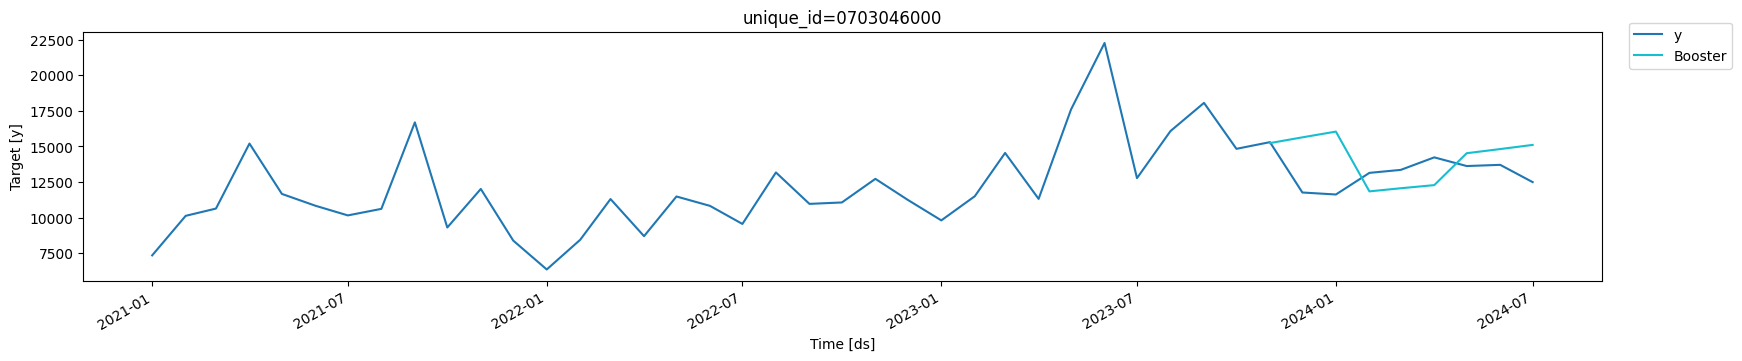

In [352]:
from mlforecast.lgb_cv import LightGBMCV
lgb_params = {
    'verbosity': -1,
    'num_leaves': 512,
}
i=2
cv = LightGBMCV(freq='MS', lags=[3,6,12],lag_transforms={
        4: [RollingMean(window_size=3),RollingMean(window_size=5)]},target_transforms=[Differences([1])],date_features=['month'])
cv_hist=cv.fit(
    tdf.filter(pl.col('unique_id')==cc[i]['CatalogNumber'])['ds','y','unique_id'].sort('ds').to_pandas(),
    n_windows=3,h=3,params=lgb_params,num_iterations=30,eval_every=3,compute_cv_preds=True)
preds=cv.cv_preds_
#preds=cv_hist.predict(3)
plot_series(df=tdf.filter(pl.col('unique_id')==cc[i]['CatalogNumber'])['ds','y','unique_id'].sort('ds').to_pandas()[:-9],forecasts_df=preds.drop(columns='window'))

In [242]:
preds

,ds,y,unique_id,Booster,window
0,2023-11-01,9688.077505,0416801100,8301.399731,0
1,2023-12-01,7588.060704,0416801100,8678.736070,0
2,2024-01-01,5573.044576,0416801100,9056.072409,0
0,2024-02-01,9324.074593,0416801100,5805.254756,1
1,2024-03-01,8568.068545,0416801100,6037.464936,1
2,2024-04-01,9073.072577,0416801100,6269.675116,1
0,2024-05-01,10248.081985,0416801100,9409.112293,2
1,2024-06-01,9128.073025,0416801100,9745.152008,2
2,2024-07-01,8988.071905,0416801100,10081.191724,2


In [52]:
def fe(df):
    df=df[['SALES_DATE','`Act Orders Rev','ASP']]
    df=df.sort('SALES_DATE')
    df=df.with_columns(lag1=pl.col('`Act Orders Rev').shift(-1),lag6=pl.col('`Act Orders Rev').shift(-6),lag12=pl.col('`Act Orders Rev').shift(-12))
    df=df.with_columns(mean6=pl.col('`Act Orders Rev').rolling_mean(6),mean3=pl.col('`Act Orders Rev').rolling_mean(3))
    df=df.with_columns(difm32=pl.col('mean3').diff(2),dif3=pl.col('`Act Orders Rev').diff(3),difm3=pl.col('mean3').diff(1),difm33=pl.col('mean3').diff(3))
    df=df.with_columns(month=pl.col('SALES_DATE').dt.month(),days=(pl.col('SALES_DATE')-pl.col('SALES_DATE').min()).dt.total_days())
    df=df.join(wd,left_on='SALES_DATE',right_on='Date',how='left')
    return df

In [54]:
for i in cc[8]['CatalogNumber']:
    df1=df.filter(pl.col('CatalogNumber')==i)
    df2=fe(df1)
    lgbm = lgb.train(params={'verbose': -1,'min_data_in_leaf':4},train_set=lgb.Dataset(label=df2['`Act Orders Rev'].to_pandas(),categorical_feature='month',data=df2.drop(['`Act Orders Rev','SALES_DATE']).to_pandas()))
lgbm

In [72]:
datetime(today.year,today.month,1)-relativedelta(months=4)

datetime.datetime(2024, 4, 1, 0, 0)

In [68]:
for i in cc[3]['CatalogNumber']:
    df1=df.filter(pl.col('CatalogNumber')==i)
    df2=fe(df1)
    for k in range(3):
        f=df.filter(pl.col('SALES_DATE')<=datetime(today.year,today.month,1)-relativedelta(months=4))
    lgbm = lgb.train({'min_data_in_leaf':4,'verbose': -1},lgb.Dataset(label=df2['`Act Orders Rev'].to_pandas(),categorical_feature='month',data=df2.drop(['`Act Orders Rev','SALES_DATE']).to_pandas()))
pr=pl.DataFrame({'SALES_DATE':df2[-5:]['SALES_DATE'],'pred':lgbm.predict(fe(df2[-5:]).drop(['`Act Orders Rev','SALES_DATE']))})
df1=df1.sort('SALES_DATE')
ss=ColumnDataSource(df1.join(pr,on='SALES_DATE',how='left').to_pandas())
p=figure(x_axis_type='datetime',y_axis_type='linear',height=400,width=800)
p.line(x='SALES_DATE', y='`Act Orders Rev', width=1.8, line_alpha=0.8,source=ss)
p.line(x='SALES_DATE', y='pred', width=1.8,color='red', line_alpha=0.8,source=ss)
p.line(x='SALES_DATE', y='L2 Stat Final Rev', width=1.8,color='GREEN', line_alpha=0.8,source=ss)
p.add_tools(HoverTool(tooltips=[('orders','@{`Act Orders Rev}{0.0f}'),('SALES_DATE','@SALES_DATE{%b-%Y}'),('pred','@pred{0.0f}')],formatters={'@SALES_DATE':'datetime'},mode='vline'))
p.add_tools(CrosshairTool(dimensions='height'))
show(p)

C:\Users\mswas\anaconda3\envs\py312\Lib\site-packages\lightgbm\basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


In [357]:
pl.DataFrame({'col':df2.drop(['`Act Orders Rev','SALES_DATE']).columns,'fi':lgbm.feature_importance()}).sort('fi',descending=True)

col,fi
str,i32
"""ASP""",92
"""mean6""",85
"""difm32""",77
"""month""",77
"""WD""",75
…,…
"""lag6""",51
"""mean3""",44
"""difm33""",43


In [ ]:
hover_selection = alt.selection_point(empty=False,fields=['month'],name='hover_selection',on='mouseover')
c=alt.Chart(df2).encode(y='order:Q',x='month:T').properties(width=800)
selectors = alt.Chart(df2).mark_bar().encode(x="month:T",opacity=alt.value(0),tooltip=['month','order']).add_params(hover_selection)
d=alt.Chart(df2).mark_rule(strokeWidth=5).encode(x="month:T",strokeOpacity= alt.value(.4)).transform_filter(hover_selection)
e=c.transform_filter('datum.tcppr>0').mark_bar(color='red',width=6,opacity=.35).encode(x='month',y=alt.Y('tcppr'),text=alt.Text('tcppr',format='.2f'))
g=c.mark_line().encode()+e+e.mark_text(dy=-12)
(g+d+selectors).resolve_axis(y='independent')